## CIFAR10 与 VGG13 实战

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.family'] = ['SimHei'] # ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus']=False 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
from tensorflow.keras import datasets, losses, metrics, Sequential, layers, optimizers, Model, Input
from tensorflow.keras.utils import plot_model, model_to_dot
import pydot
# import graphviz

In [5]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [ ]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [7]:
def preprocessing(X, y):
    X = tf.cast(X, dtype=tf.float32) / 255
    y = tf.cast(y, dtype=tf.int32)
    y_onehot = tf.one_hot(y, depth=10)
    return X, y_onehot

In [8]:
train_db = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_db = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_db = train_db.shuffle(10000).batch(128).map(preprocessing)
test_db = test_db.shuffle(10000).batch(128).map(preprocessing)

In [9]:
sample = next(iter(train_db))
tf.reduce_max(sample[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

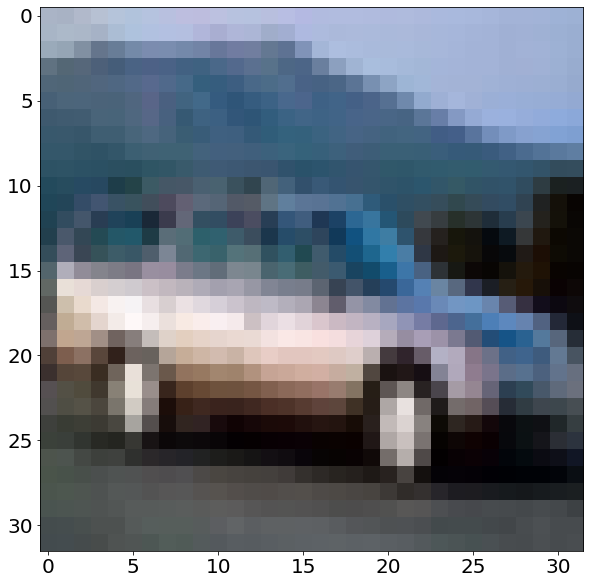

In [13]:
plt.imshow(X_train[4]/255)

In [14]:
pool_layer = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
out_1 = pool_layer(X_train[4][np.newaxis])
out_1.shape

TensorShape([1, 16, 16, 3])

In [17]:
pool_layer = layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same')
out_2 = pool_layer(X_train[4][tf.newaxis])
out_2.shape

TensorShape([1, 32, 32, 3])

In [16]:

np.array_equal(out_1, out_2)

False

CIFAR10 图片识别任务并不简单，这主要是由于 CIFAR10 的图片内容需要大量细节才能呈现，而保存的图片分辨率仅有32 × 32，使得部分主体信息较为模糊，甚至人眼都很难分辨。

In [ ]:
# 1. 卷积子网络
conv_layers = [
    # 64个 3X3 的卷积核 输出与输入同大小
    layers.Conv2D(64, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    # 池化层 高宽减半
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元2  输出通道提升至 128，高宽大小减半
    layers.Conv2D(128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元3  输出通道提升至 256，高宽大小减半
    layers.Conv2D(256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元4  输出通道提升至 512，高宽大小减半
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    # Conv-Conv-Pooling 单元4  输出通道提升至 512，高宽大小减半
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),                       
    layers.Conv2D(512, kernel_size=(3, 3), padding='SAME', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu', input_shape=(1, 1, 512)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation=None)
]

In [ ]:
VGG13 = Sequential(conv_layers)

In [ ]:
plot_model(VGG13, show_shapes=True)

In [ ]:
VGG13.summary()

In [ ]:
(3 * 3 * 3 + 1) * 64

In [ ]:
(3 * 3 * 64 + 1) * 64

In [ ]:
(3*3*64 + 1) * 128

In [ ]:
50000 / 128

In [ ]:
def VGG13():
    loss = []
    acc = []
    metric_acc = metrics.Accuracy()
    optimizer = optimizers.Adam(0.0001)
    conv_net.build(input_shape=(None, 32, 32, 3))
    fc_net.build(input_shape=(None, 512)) 
    variables = conv_net.trainable_variables + fc_net.trainable_variables
    
    for epoch in range(10):
        for step, (x, y) in enumerate(train_db):
            with tf.GradientTape() as tape:
                out = VGG(x)
                # print(out.shape)
                # y_onehot = tf.one_hot(y, depth=10)
                cost = losses.categorical_crossentropy(y, out, from_logits=True)
                cost =tf.reduce_mean(cost)
            grads = tape.gradient(cost, variables)
            optimizer.apply_gradients(zip(grads, variables))
            
            if step % 100 == 0:
                loss.append(float(cost))
                print(f"epoch: {epoch}, step: {step}, loss: {float(cost)}")
        
        # 每个epoch 检测一次test
        metric_acc.reset_states()
        for x, y in test_db:
            out = conv_net(x)
            out = tf.reshape(out, (-1, 512))

            out = fc_net(out)
            y_pred = tf.argmax(out, axis=-1)
            metric_acc.update_state(y, y_pred)
        print(f"epoch :{epoch},  accuracy: {float(metric_acc.result())}")
        acc.append(float(metric_acc.result()))
    return loss, acc

In [ ]:
loss, acc = VGG16()

## 卷积层变种

### 空洞卷积(Dilated/Atrous Convolution)

普通的卷积层为了减少网络的参数量，卷积核的设计通常选择较小的 $1\times1$ 和$3 \times 3$感受野大小。小卷积核使得网络提取特征时的感受野区域有限，但是增大感受野的区域又会增加网络的参数量和计算代价.

空洞卷积在普通卷积的感受野上增加一个Dilation Rate 参数, 用于控制感受野区域的采样步长
![](./空洞卷积.png)

尽管Dilation Rate 的增大会使得感受野区域增大，但是实际参与运算的点数仍然保持不变。

In [ ]:
x = tf.random.normal([1, 7, 7, 1])
# 空洞卷积  1个 3 X 3 的核
layer = layers.Conv2D(1, kernel_size=(3, 3), strides=1, dilation_rate=2)
out = layer(x)
out.shape

### 转置卷积
转置卷积(Transposed Convolution，或Fractionally Strided Convolution)通过在输入之间填充大量的padding 来实现输出高宽大于输入高宽的效果，从而实现向上采样的目的.转置卷积具有“**放大特征图**”的功能

转置卷积与普通卷积并不是互为逆过程，不能恢复出对方的输入内容，仅能恢复出等大小的张量.

例: 
- 输入$i = 2 \times 2$ 单通道特征图, 转置卷积核$k=3 \times 3$, 填充$p=0$, 步长$s=2$;
- $2 \times 2$ 内部均匀填充$s-1$个空白输入点 ---> $3 \times 3$;
- $3 \times 3$ 周围填充$𝑘 − 𝑝 −1 = 3 − 0−1 = 2行/列$, ---> $7 \times 7$;
- $7 \times 7$ 与 $3 \times 3$的卷积核卷积, 步长$s' = 1$(固定), 填充$p=0$ ---> $o = 5 \times 5$的输出;

- 恢复: $5 \times 5$ 与 $3 \times 3$的卷积核卷积, 填充$p=0$, 步长$s=2$ ----> $2 \times 2$的输入 

在𝑜 + 2𝑝 − 𝑘为s 倍数时，满足关系:
$$o = (i-1)s +k-2p$$

In [4]:
x = tf.range(25) + 1
# [b, h, w, c]
x = tf.reshape(x, [1, 5, 5, 1])
x = tf.cast(x, dtype=tf.float32)

# 3X3 卷积核
w = tf.constant([[-1, 2, -3.], [4, -5, 6], [-7, 8, -9]])
w = tf.expand_dims(w, axis=2)
w =  tf.expand_dims(w, axis=3)
# [f_w, f_h, c_in, c_out]
w.shape

TensorShape([3, 3, 1, 1])

In [5]:
# 填充0, 步长2
out = tf.nn.conv2d(x, w, strides=2, padding='VALID')
out

<tf.Tensor: id=14, shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ -67.],
         [ -77.]],

        [[-117.],
         [-127.]]]], dtype=float32)>

In [ ]:
tf.nn.conv2d_transpose?

In [8]:
# 将普通卷积作为转置卷积的输入
# 输入:2*2   核:3*3
xx = tf.nn.conv2d_transpose(out, w, strides=2, padding='VALID', output_shape=[1, 5, 5, 1])
xx.shape

TensorShape([1, 5, 5, 1])

In [10]:
np.squeeze(xx.numpy())

array([[   67.,  -134.,   278.,  -154.,   231.],
       [ -268.,   335.,  -710.,   385.,  -462.],
       [  586.,  -770.,  1620.,  -870.,  1074.],
       [ -468.,   585., -1210.,   635.,  -762.],
       [  819.,  -936.,  1942., -1016.,  1143.]], dtype=float32)

卷积运算的输出大小
$$o = ⌊\frac {i + 2\cdot p_h - k}{s}⌋ + 1$$
当𝒐 + 𝟐𝒑 − 𝒌不为𝒔倍数时, 当s>1, 向下取整会使得多种不同大小的输入i得到相同大小的输出o.


In [42]:
x = tf.random.normal([1,6,6,1])
out = tf.nn.conv2d(x, w, strides=2, padding='VALID')
out.shape

TensorShape([1, 2, 2, 1])

In [12]:
xx = tf.nn.conv2d_transpose(out, w, strides=2, padding='VALID', output_shape=[1, 5, 5, 1])
xx.shape

TensorShape([1, 5, 5, 1])

In [13]:
# 指定output_shape 得到输出尺寸
xx = tf.nn.conv2d_transpose(out, w, strides=2, padding='VALID', output_shape=[1, 6, 6, 1])
xx.shape

TensorShape([1, 6, 6, 1])

In [14]:
xx = tf.nn.conv2d_transpose(out, w, strides=3, padding='SAME', output_shape=[1, 6, 6, 1])
xx.shape

TensorShape([1, 6, 6, 1])

In [37]:
I = np.arange(16) + 1
I = I.reshape(4, 4)

In [45]:
K = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])

In [46]:
K[..., np.newaxis, np.newaxis].shape

(3, 3, 1, 1)

In [41]:
I[np.newaxis, ..., np.newaxis].shape

(1, 4, 4, 1)

In [49]:
O = tf.nn.conv2d(tf.cast(I[np.newaxis, ..., np.newaxis], dtype=tf.float32), K[..., np.newaxis, np.newaxis], strides=1, padding='VALID')
O

<tf.Tensor: id=170, shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[24.],
         [28.]],

        [[40.],
         [44.]]]], dtype=float32)>

In [54]:
# 只能恢复相同的形状
tf.nn.conv2d_transpose(O,  K[..., np.newaxis, np.newaxis], strides=1, padding='VALID', output_shape=[1, 4, 4, 1])

<tf.Tensor: id=180, shape=(1, 4, 4, 1), dtype=float32, numpy=
array([[[[24.],
         [28.],
         [24.],
         [28.]],

        [[40.],
         [44.],
         [40.],
         [44.]],

        [[24.],
         [28.],
         [24.],
         [28.]],

        [[40.],
         [44.],
         [40.],
         [44.]]]], dtype=float32)>

#### 矩阵角度理解
普通Conv2d运算:
- X:(4, 4), W:(3, 3), 步长为1，无padding
- X打平X'(1, 16), W转为稀疏矩阵W'(4, 16)
- 输出$O'= W'@X'$ (4,1), reshape 得到O(2, 2)

转置卷积
- $W'$转置后与$O'$矩阵相乘$X'=W'^T@O'$大小为(16, 1), reshape得到(4, 4)

####  转置卷积层

- 当padding=’VALID’时，输出大小表达为:
   $$o=(i-1)s+k$$
- 当设置padding=’SAME’时，输出大小表达为:
   $$o = i \cdot s$$

In [15]:

layer = layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='VALID')
xx2 = layer(out)
xx2.shape

TensorShape([1, 4, 4, 1])

In [16]:
layer = layers.Conv2DTranspose(1, kernel_size=3, strides=3, padding='SAME')
xx2 = layer(out)
xx2.shape

TensorShape([1, 6, 6, 1])

### 分离卷积(Separable Convolution)

普通卷积在对多通道输入进行运算时，卷积核的每个通道与输入的每个通道分别进行卷积运算，得到多通道的特征图，再对应元素相加产生单个卷积核的最终输出
$$输入[1, h, w, 3] \odot 多卷积核[3, 3, 3, 4] \rightarrow 中间特征 \rightarrow \sum对应元素求和 = 
输出[1, h', w', 4]
$$

分离卷积流程:
$$输入[1, h, w, 3] \odot 单卷积核[3, 3, 3, 1] \rightarrow 中间特征 \rightarrow \\ \odot 4个1\times 1 卷积核[1, 1, 3, 4] =
输出[1, h', w', 4]
$$

可以看到，分离卷积层包含了两步卷积运算，第一步卷积运算是单个卷积核，第二个卷积运算包含了多个卷积核。

优势:
- 相同输入要产生相同大小输出, 分离卷积的参数量约是普通卷积的$\frac 1 3$

$1 \times 1$卷积核的作用:
- 实现信息的跨通道交互和整合。
- 对卷积核通道数进行降维和升维，减小参数量, 降低计算成本。

## 深度残差网络ResNet
当模型加深以后，网络变得越来越难训练，这主要是由于**梯度弥散**和**梯度爆炸**现象造成的。在较深层数的神经网络中，梯度信息由网络的末层逐层传向网络的首层时，传递的过程中会出现梯度接近于0 或梯度值非常大的现象。网络层数越深，这种现象可能会越严重。

通过在输入和输出之间添加一条直接连接的**Skip Connection**可以让神经网络具有回退的能力.它可以从某一层网络层获取激活，然后迅速反馈给另外一层，甚至是神经网络的更深层。我们可以利用跳跃连接构建能够训练深度网络的**ResNet**.

### ResNet 原理
ResNet 通过在卷积层的输入和输出之间添加Skip Connection 实现层数回退机制, 输入$x$通过2个卷积层, 得到特征变换后的输出$\mathcal F(x)$, 与输入$x$进行对应元素的相加运算, 得到最终输出$\mathcal H(x)$:
$$\mathcal H(x) = x + \mathcal F(x)$$
> 需要保持输入$x$的shape与$\mathcal F(x)$的shape完全一致

![](./残差模块.png)
$\mathcal H(x)$叫作残差模块(Residual Block, ResBlock)

In [17]:
layers.Conv2D?

In [ ]:
# ResBlock的实现
class ResBlock(layers.Layer):
    def __init__(self, fliter_num, stride=1):
        super().__init__()
        # f(x)函数包括2个普通的卷积层
        self.conv = layers.Conv2D(fliter_num, (3,3), strides=stride, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
        # 第二个卷积层步长为1,
        self.conv2 = layers.Conv2D(fliter_num, (3,3), strides=1, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        
        if stride != 1:  # F 与 x的形状不相同
            self.downsample = Sequential()
            # 使用 1X1 卷积核
            self.downsample.add(layers.Conv2D(fliter_num, (1, 1), strides=stride))
        else:
            # 直接连接
            self.downsample = lambda x:x
            
    def call(self, x):
        # 前向传播  H(x) = x + F(x)
        out = self.conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.downsample(x)
        
        output = layers.add([out, identity])
        # 得到H(x)后再进过激活函数 
        output = tf.nn.relu(output)
        return output

In [ ]:
class ResNet(Model):
    def __init__(self, layer_blocks, num_classe=10):
        super().__init__()
         # 根网络
        self.stem = Sequential([
            layers.Conv2D(64, (3, 3), strides=(1, 1), input_shape=(32, 32, 3)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        ])
        # 4个block 每个block有多个残差模块
        self.layer1 = self.build_resblock(64, layer_blocks[0])
        self.layer2 = self.build_resblock(128, layer_blocks[1], stride=2)
        self.layer3 = self.build_resblock(256, layer_blocks[2], stride=2)
        self.layer4 = self.build_resblock(512, layer_blocks[3], stride=2)
        
        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classe)
    
    def build_resblock(self, fliter_num, block_num, stride=1):
        res_blocks = Sequential([])
        # 2个不同的block之间 残差模块shortcut上使用1x1卷积
        res_blocks.add(ResBlock(fliter_num, stride))
        
        for _ in range(1, block_num):
            # 其他的resblock  步长全为1
            res_blocks.add(ResBlock(fliter_num, stride=1))
        return res_blocks
    
    def call(self, inputs):
        # 根网络
        x = self.stem(inputs)
        # 4个模块
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 池化层
        x = self.avgpool(x)
        # 全连接层
        x = self.fc(x)
        
        return x
        

In [27]:
layers.GlobalAveragePooling2D?
# 空间维度(height和width)的全局平均 
# Output shape:
#     2D tensor with shape `(batch_size, channels)`.

In [ ]:
def resnet(layer_blocks, input_shape, num_classe=10):
    """
    layer_blocks: 每"层"的残差模块数量
    """
    def resblock(X, fliter_num, stride=1):
        """
        每个残差模块由2个卷积层组成
        """
        # 通过设置第一个卷积层的卷积步长 改变h和w
        conv = layers.Conv2D(fliter_num, (3,3), strides=stride, padding='SAME')
        bn1 = layers.BatchNormalization()
        relu = layers.ReLU()

        # 第二个卷积层步长为1
        conv2 = layers.Conv2D(fliter_num, (3,3), strides=1, padding='SAME')
        bn2 = layers.BatchNormalization()

        if stride != 1:  # F 与 x的形状不相同
            downsample = layers.Conv2D(fliter_num, (1, 1), strides=stride)
            # 使用 1X1 卷积核
        else:
            # 直接连接
            downsample = lambda x:x

        out = conv(X)
        out = bn1(out)
        out = relu(out)
        out = conv2(out)
        out = bn2(out)
        identity = downsample(X)
        # skip-connection 
        # out = layers.Add()([out, identity])
        out = layers.add([out, identity])
        out = layers.ReLU()(out)

        return out
    
    def build_resblock(X, fliter_num, block_num, stride=1):

        # 第一个block 要注意进行 1x1卷积处理

        out = resblock(X, fliter_num, stride)
        
        for _ in range(1, block_num):
            # 其他的resblock  步长全为1
            out = resblock(out, fliter_num, stride=1)
        return out
    
    X_inputs = Input(input_shape)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), input_shape=input_shape)(X_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
    x = build_resblock(x, 64, layer_blocks[0])
    x = build_resblock(x, 128, layer_blocks[1], stride=2)
    x = build_resblock(x, 256, layer_blocks[2], stride=2)k
    x = build_resblock(x, 512, layer_blocks[3], stride=2)
    
    # 空间维度(height和width)的全局平均 
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classe)(x)
    
    model = Model(inputs=X_inputs, outputs=out)
    return model

In [30]:
28*28*32*5*5*16


10035200

In [ ]:
model2 = resnet([2,2,2,2], (32, 32, 3), 10)
plot_model(model2, show_shapes=True, to_file='ResNet18.png')

In [ ]:
model2.summary()


In [ ]:
model_to_dot(model2, show_shapes=True).write('ResNet18', prog='dot', format='svg')

In [ ]:
pydot.Dot.create?

In [ ]:
graphviz.Source(model_to_dot(model2, show_shapes=True)).render('ResNet18')

In [ ]:
model = ResNet([2, 2, 2, 2], 10)
model.build(input_shape=(None, 32, 32, 3))
model.summary()

In [ ]:
(3*3*3+1)*64 + 4*64

In [ ]:
((3*3*64 +1) *64 *2 + 4*64*2)*2

In [ ]:
model2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam', metrics=['accuracy'])
hist = model2.fit(train_db, epochs=20, validation_data=test_db, validation_freq=4)
model.save('resnet18.h5')

## DenseNet

DenseNet 将前面所有层的特征图信息通过Skip Connection 与当前层输出进行聚合，与ResNet的对应位置相加方式不同，DenseNet 采用在通道轴𝑐维度进行拼接操作，聚合特征信息。

DenseNet:

https://github.com/liuzhuang13/DenseNet

In [ ]:
# resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)